# **Paper Replication of ViT Paper**

Paper link: [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)

# 0. Set up libraries

In [ ]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision version not as required, installing nightly version")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.8.0+cu126
torchvision version: 0.23.0+cu126


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 29.55 MiB/s, done.
Resolving deltas: 100% (2657/2657), done.
Updating files: 100% (248/248), done.


# 1. Get the Data

In [ ]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi",
                           remove_source=True)

image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# 2. Create Datasets & DataLoaders

In [ ]:
IMAGE_SIZE = 224 # Table 3 of ViT Paper

manual_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [ ]:
# The paper uses 4096 batch size, but this may be too big for our small hardware, so we will use batch size of 32 instead.

BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

In [ ]:
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

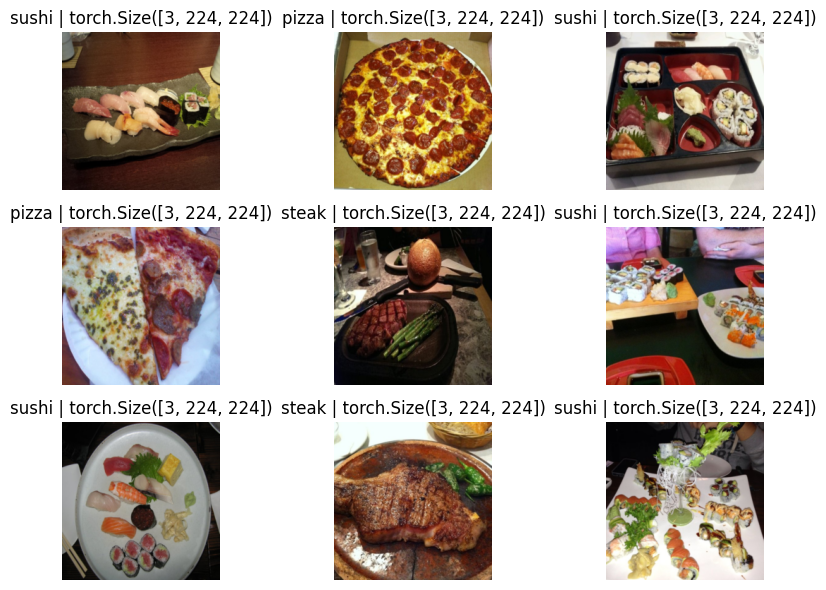

In [ ]:
# Visualize random image from train_dataloader

import random

plt.figure(figsize=(9, 6))

for i in range(9):
    image_batch, label_batch = next(iter(train_dataloader))

    # Get the actual batch size of the current batch
    current_batch_size = len(image_batch)

    # Get a random index from the current batch size
    random_idx = random.randint(0, current_batch_size - 1)

    # Get the image and label at the random index
    image, label = image_batch[random_idx], label_batch[random_idx]
    shape = image.shape

    plt.subplot(3, 3, i+1)
    plt.imshow(image.permute(1, 2, 0)) # # [color_channels, height, width] -> [height, width, color_channels]
    plt.title(f"{class_names[label]} | {shape}") # Use class_names to display the label name
    plt.axis("off") # Turn off axis

plt.tight_layout()
plt.show()

# 3. Overview of the ViT Paper Architecture

## 3.1 Exploring Figure 1

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs.png" width=900 alt="figure 1 from the original vision transformer paper"/>

The ViT architecture is comprised of several stages:
* **Patch + Position Embedding (inputs)** - Turns the input image into a sequence of image patches and adds a position number to specify in what order the patch comes in.
* **Linear projection of flattened patches (Embedded Patches)** - The image patches get turned into an **embedding**, the benefit of using an embedding rather than just the image values is that an embedding is a *learnable* representation (typically in the form of a vector) of the image that can improve with training.
* **Norm** - This is short for "[Layer Normalization](https://paperswithcode.com/method/layer-normalization)" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer [`torch.nn.LayerNorm()`](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).
* **Multi-Head Attention** - This is a [Multi-Headed Self-Attention layer](https://paperswithcode.com/method/multi-head-attention) or "MSA" for short. You can create an MSA layer via the PyTorch layer [`torch.nn.MultiheadAttention()`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html).
* **MLP (or [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron))** - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a `forward()` method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two [`torch.nn.Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers with a [`torch.nn.GELU()`](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) non-linearity activation in between them (section 3.1) and a [`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) layer after each (Appendix B.1).
* **Transformer Encoder** - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
* **MLP Head** - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.

## 3.2 Exploring the Four Equations

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=650 alt="four mathematical equations from the vision transformer machine learning paper"/>

Let's map these descriptions to the ViT architecture in Figure 1.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-mapping-the-four-equations-to-figure-1.png" width=1000 alt="mapping the vision transformer paper figure 1 to the four equations listed in the paper"/>

In all equations (except equation 4), "$\mathbf{z}$" is the raw output of a particular layer:

1. $\mathbf{z}_{0}$ is "z zero" (this is the output of the initial patch embedding layer).
2. $\mathbf{z}_{\ell}^{\prime}$ is "z of a particular layer *prime*" (or an intermediary value of z).
3. $\mathbf{z}_{\ell}$ is "z of a particular layer".

And $\mathbf{y}$ is the overall output of the architecture.

### 3.2.1 Equation 1

$$
\begin{aligned}
\mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}
$$

This equation deals with the class token, patch embedding and position embedding ($\mathbf{E}$ is for embedding) of the input image.

In vector form, the embedding might look something like:

```python
x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]
```

Where each of the elements in the vector is learnable (their `requires_grad=True`).

### 3.2.2 Equation 2

$$
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}
$$

This says that for every layer from $1$ through to $L$ (the total number of layers), there's a Multi-Head Attention layer (MSA) wrapping a LayerNorm layer (LN)

We'll call this layer the "MSA block".

In pseudocode, this might look like:

```python
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
```

### 3.2.3 Equation 3

$$
\begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\end{aligned}
$$

This says that for every layer from $1$ through to $L$ (the total number of layers), there's also a Multilayer Perceptron layer (MLP) wrapping a LayerNorm layer (LN).

We'll call this layer the "MLP block".

In pseudocode, this might look like:

```python
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

### 3.2.4 Equation 4

$$
\begin{aligned}
\mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & &
\end{aligned}
$$

This says for the last layer $L$, the output $y$ is the 0 index token of $z$ wrapped in a LayerNorm layer (LN).

Or in our case, the 0 index of `x_output_MLP_block`:

```python
y = Linear_layer(LN_layer(x_output_MLP_block[0]))
```

## 3.3 Exploring Table 1

The final piece of the ViT architecture puzzle we'll focus on (for now) is Table 1.

| Model | Layers | Hidden size $D$ | MLP size | Heads | Params |
| :--- | :---: | :---: | :---: | :---: | :---: |
| ViT-Base | 12 | 768 | 3072 | 12 | $86M$ |
| ViT-Large | 24 | 1024 | 4096 | 16 | $307M$ |
| ViT-Huge | 32 | 1280 | 5120 | 16 | $632M$ |

<div align=center>
    <i>Table 1: Details of Vision Transformer model variants. Source: <a href="https://arxiv.org/abs/2010.11929">ViT paper</a>.</i>
</div>
<br>

This table showcasing the various hyperparameters of each of the ViT architectures.

We're going to focus on replicating ViT-Base (start small and scale up when necessary) but we'll be writing code that could easily scale up to the larger variants.

Breaking the hyperparameters down:
* **Layers** - How many Transformer Encoder blocks are there? (each of these will contain a MSA block and MLP block)
* **Hidden size $D$** - This is the embedding dimension throughout the architecture, this will be the size of the vector that our image gets turned into when it gets patched and embedded. Generally, the larger the embedding dimension, the more information can be captured, the better results. However, a larger embedding comes at the cost of more computation.
* **MLP size** - What are the number of hidden units in the MLP layers?
* **Heads** - How many heads are there in the Multi-Head Attention layers?
* **Params** - What are the total number of parameters of the model? Generally, more parameters leads to better performance but at the cost of more computation. You'll notice even ViT-Base has far more parameters than any other model we've used so far.

We'll use these values as the hyperparameter settings for our ViT architecture.

# 4. Replicating the ViT Paper

## 4.1 Equation 1: (Class Token, Patch Embedding) + Position Embedding

We'll start with the **patch embedding**.

This means we'll be turning our input images in a sequence of patches and then embedding those patches.

We'll begin by following the opening paragraph of section 3.1 of the ViT paper (bold mine):

> The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the **patch embeddings**.

And size we're dealing with image shapes, let's keep in mind the line from Table 3 of the ViT paper:

> Training resolution is **224**.

Let's break down the text above.

* $D$ is the size of the **patch embeddings**, different values for $D$ for various sized ViT models can be found in Table 1.
* The image starts as 2D with size ${H \times W \times C}$.
    * $(H, W)$ is the resolution of the original image (height, width).
    * $C$ is the number of channels.
* The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.
    * $(P, P)$ is the resolution of each image patch (**patch size**).
    * $N=H W / P^{2}$ is the resulting number of patches, which also serves as the input sequence length for the Transformer.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-annotated.png" width=900 alt="mapping the vit architecture diagram positional and patch embeddings portion to the relative mathematical equation describing what's going on"/>

### 4.1.1 Calculating patch embedding input and output shapes by hand

In [ ]:
height = 224 # H
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (Number of patches)
number_of_patches = (height * width) // (patch_size ** 2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


Input and output shapes of the patch embedding layers:
* **Input**: A 2D image with size $H \times W \times C$
* **Output**: A sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

In [ ]:
# Input shape
embedding_layers_input_shape = (height, width, color_channels)
print(f"Input shape (single 2D image): {embedding_layers_input_shape}")

# Output shape
embedding_layers_output_shape = (number_of_patches, (patch_size**2 * color_channels))
print(f"Output shape (single 2D image flattened into patches): {embedding_layers_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


### 4.1.2 Turning a single image into patches

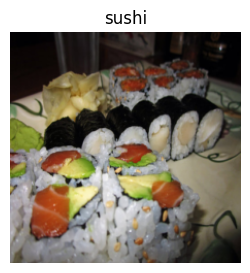

In [ ]:
# Get a single image
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]

# Plot the image
plt.figure(figsize=(3, 3))
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis("off");

In [ ]:
# Setup hyperparameters and make sure that img_size and patch_size are compatible
img_size = 224
patch_size = 16
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
num_patches = img_size // patch_size

print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

Number of patches per row: 14        
Number of patches per column: 14        
Total patches: 196        
Patch size: 16 pixels x 16 pixels


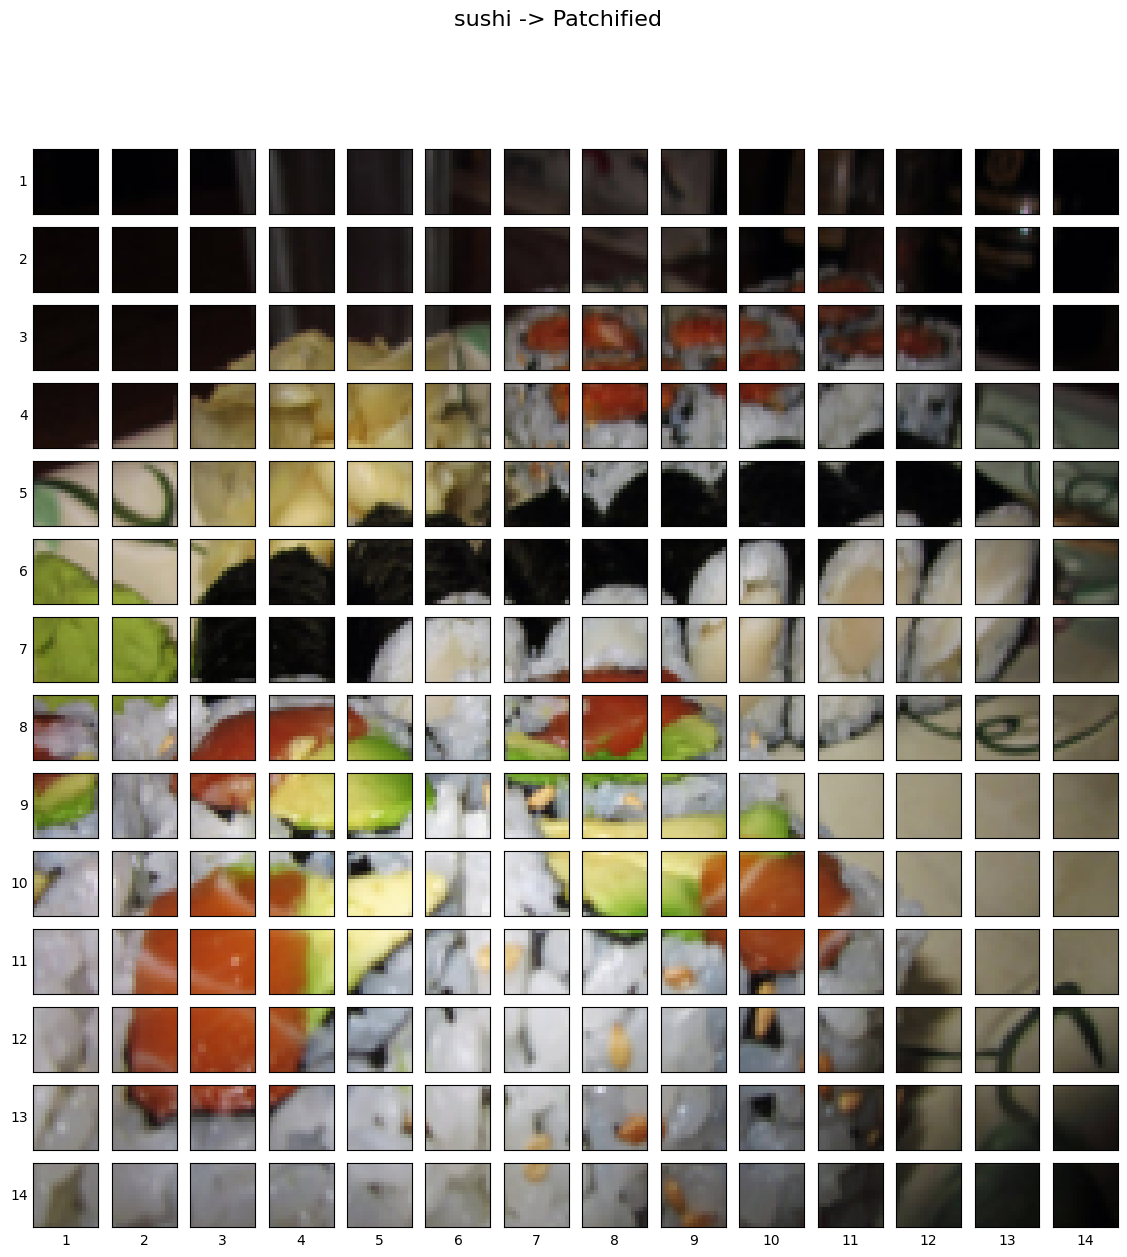

In [ ]:
# Permute the image from C x H x W to H x W x C
image_permuted = image.permute(1, 2, 0)

# Create series of subplots for the patches
fig, ax = plt.subplots(nrows=num_patches,
                       ncols=num_patches,
                       figsize=(num_patches, num_patches),
                       sharex=True,
                       sharey=True)

# Loop through height and width of the image to create the patches
for i, patch_height in enumerate(range(0, img_size, patch_size)): # Top - Bottom, step by patch_size
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # Left - Right, step by patch_size
        # Plot the image
        ax[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through the height
                                       patch_width:patch_width+patch_size, # iterate through the width
                                       :]) # all the colour channels

        # Set up the label information
        ax[i, j].set_ylabel(i+1, # The patch index
                            rotation="horizontal",
                            horizontalalignment="right",
                            verticalalignment="center")
        ax[i, j].set_xlabel(j+1)

        # Remove the ticks for clarity
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

### 4.1.3 Turning the ViT patch embedding layer into a PyTorch module

In [ ]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768. -> P^2 * C
    """
    def __init__(self,
                 in_channels: int=3,
                 patch_size: int=16,
                 embedding_dim: int=768):
        super().__init__()

        # Use conv2d layer to turn the image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size)

        # Use flatten layer to flatten the patch feature maps
        self.flatten = nn.Flatten(start_dim=2, # Only flatten the patch feature maps
                                  end_dim=3)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Check the input shape
        image_height, image_width = x.shape[-2], x.shape[-1]
        assert image_height % patch_size == 0, f"Input image height ({image_height}) must be divisible by patch size ({patch_size})"
        assert image_width % patch_size == 0, f"Input image width ({image_width}) must be divisible by patch size ({patch_size})"

        # Patch the image
        x_patched = self.patcher(x)

        # Flatten the patched image
        x_flattened = self.flatten(x_patched)

        # Permute the flattened image to have batch_size, sequence_length, embedding_dim
        x_permuted = x_flattened.permute(0, 2, 1)

        return x_permuted

In [ ]:
# Try on a single image
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


The output shape matches the ideal input and output shapes we'd like to see from the patch embedding layer:

* **Input:** The image starts as 2D with size ${H \times W \times C}$.
* **Output:** The image gets converted to a 1D sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

Where:
* $(H, W)$ is the resolution of the original image.
* $C$ is the number of channels.
* $(P, P)$ is the resolution of each image patch (**patch size**).
* $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer.
    
We've now replicated the patch embedding for equation 1 but not the class token/position embedding.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-replicating-the-patch-embedding-layer.png" width=900 alt="replicating the vision transformer architecture patch embedding layer"/>

*Our `PatchEmbedding` class (right) replicates the patch embedding of the ViT architecture from Figure 1 and Equation 1 from the ViT paper (left). However, the learnable class embedding and position embeddings haven't been created yet.*

In [ ]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# # Get a summary of the input and outputs of PatchEmbedding
summary(patchify,
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

### 4.1.4 Create the Class Token Embedding

$\mathbf{x}_\text {class }$ from equation 1.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-the-class-token.png" width=900 alt="class token embedding highlight from the vision transformer paper figure 1 and section 3.1"/>

*Left: Figure 1 from the ViT paper with the "classification token" or `[class]` embedding token we're going to recreate highlighted. Right: Equation 1 and section 3.1 of the ViT paper that relate to the learnable class embedding token.*

Reading the second paragraph of section 3.1 from the ViT paper, we see the following description:

> Similar to BERT's `[ class ]` token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4).

> **Note:** [BERT](https://arxiv.org/abs/1810.04805) (Bidirectional Encoder Representations from Transformers) is one of the original machine learning research papers to use the Transformer architecture to achieve outstanding results on natural language processing (NLP) tasks and is where the idea of having a `[ class ]` token at the start of a sequence originated, class being a description for the "classification" class the sequence belonged to.

So we need to "prepend a learnable embedding to the sequence of embedded patches".

In [ ]:
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.0298, -0.0162, -0.0343,  ...,  0.0140, -0.0067,  0.0146],
         [-0.0356, -0.0084, -0.0363,  ...,  0.0227, -0.0129,  0.0087],
         [-0.1125,  0.0523, -0.0125,  ...,  0.0361, -0.0493,  0.0117],
         ...,
         [-0.2595,  0.0492, -0.0592,  ...,  0.1573, -0.0493,  0.0891],
         [-0.0904, -0.0158, -0.0505,  ...,  0.0786, -0.0628,  0.0481],
         [-0.0438, -0.0071, -0.0356,  ...,  0.0255, -0.0270,  0.0255]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


Let's create a learnable embedding for the class token.

To do so, we'll get the batch size and embedding dimension shape and then we'll create a `torch.ones()` tensor in the shape `[batch_size, 1, embedding_dimension]`.

And we'll make the tensor learnable by passing it to `nn.Parameter()` with `requires_grad=True`.

In [ ]:
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as
# the embedding dimension (D) using nn.Parameter()
class_token = nn.Parameter(data=torch.ones(batch_size, 1, embedding_dim),
                           requires_grad=True)

print(class_token[:, :, :10])
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


> **Note:** Here we're only creating the class token embedding as [`torch.ones()`](https://pytorch.org/docs/stable/generated/torch.ones.html) for demonstration purposes, in reality, you'd likely create the class token embedding with [`torch.randn()`](https://pytorch.org/docs/stable/generated/torch.randn.html) (since machine learning is all about harnessing the power of controlled randomness, you generally start with a random number and improve it over time).

In [ ]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1)

print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0298, -0.0162, -0.0343,  ...,  0.0140, -0.0067,  0.0146],
         [-0.0356, -0.0084, -0.0363,  ...,  0.0227, -0.0129,  0.0087],
         ...,
         [-0.2595,  0.0492, -0.0592,  ...,  0.1573, -0.0493,  0.0891],
         [-0.0904, -0.0158, -0.0505,  ...,  0.0786, -0.0628,  0.0481],
         [-0.0438, -0.0071, -0.0356,  ...,  0.0255, -0.0270,  0.0255]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


We could see that the class token has been successfully prepended in the first row of ones.

### 4.1.5 Create the Position Embedding

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-the-position-embeddings.png" width=900 alt="extracting the position embeddings from the vision transformer architecture and comparing them to other sections of the vision transformer paper"/>

*Left: Figure 1 from the ViT paper with the position embedding we're going to recreate highlighted. Right: Equation 1 and section 3.1 of the ViT paper that relate to the position embedding.*

> Position embeddings are added to the patch embeddings to retain positional information. We use **standard learnable 1D position embeddings**, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

This positional information can be important when considering what's in an image (without positional information and a flattened sequence could be seen as having no order and thus no patch relates to any other patch).

In [ ]:
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0298, -0.0162, -0.0343,  ...,  0.0140, -0.0067,  0.0146],
         [-0.0356, -0.0084, -0.0363,  ...,  0.0227, -0.0129,  0.0087],
         ...,
         [-0.2595,  0.0492, -0.0592,  ...,  0.1573, -0.0493,  0.0891],
         [-0.0904, -0.0158, -0.0505,  ...,  0.0786, -0.0628,  0.0481],
         [-0.0438, -0.0071, -0.0356,  ...,  0.0255, -0.0270,  0.0255]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


Equation 1 states that the position embeddings ($\mathbf{E}_{\text {pos }}$) should have the shape $(N + 1) \times D$:

$$\mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}$$

Where:
* $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer (number of patches).
* $D$ is the size of the **patch embeddings**, different values for $D$ can be found in Table 1 (embedding dimension).

So let's make a learnable 1D embedding with `torch.ones()` to create $\mathbf{E}_{\text {pos }}$.

In [ ]:
# Check the value of N (number of patches) and D (embedding dimension)
print(f"Number of patches: {number_of_patches}")
print(f"Embedding dimension: {embedding_dim}")

Number of patches: 196
Embedding dimension: 768


In [ ]:
# Create the learnable 1D position embeddings
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dim),
                                  requires_grad=True)

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


> **Note:** Only creating the position embedding as `torch.ones()` for demonstration purposes, in reality, you'd likely create the position embedding with `torch.randn()` (start with a random number and improve via gradient descent).

Position embeddings created!

Let's add them to our sequence of patch embeddings with a prepended class token.

In [ ]:
# Check the patch embedded image with class token prepended
print(patch_embedded_image_with_class_embedding)

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0298, -0.0162, -0.0343,  ...,  0.0140, -0.0067,  0.0146],
         [-0.0356, -0.0084, -0.0363,  ...,  0.0227, -0.0129,  0.0087],
         ...,
         [-0.2595,  0.0492, -0.0592,  ...,  0.1573, -0.0493,  0.0891],
         [-0.0904, -0.0158, -0.0505,  ...,  0.0786, -0.0628,  0.0481],
         [-0.0438, -0.0071, -0.0356,  ...,  0.0255, -0.0270,  0.0255]]],
       grad_fn=<CatBackward0>)


In [ ]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9702, 0.9838, 0.9657,  ..., 1.0140, 0.9933, 1.0146],
         [0.9644, 0.9916, 0.9637,  ..., 1.0227, 0.9871, 1.0087],
         ...,
         [0.7405, 1.0492, 0.9408,  ..., 1.1573, 0.9507, 1.0891],
         [0.9096, 0.9842, 0.9495,  ..., 1.0786, 0.9372, 1.0481],
         [0.9562, 0.9929, 0.9644,  ..., 1.0255, 0.9730, 1.0255]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


Notice how the values of each of the elements in the embedding tensor increases by 1 (this is because of the position embeddings being created with `torch.ones()`).

## 4.2 Equation 2: Multi-Head Self Attention (MSA)

Recall equation 2 states:

$$
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}
$$

This indicates a Multi-Head Attention (MSA) layer wrapped in a LayerNorm (LN) layer with a residual connection (the input to the layer gets added to the output of the layer).

We'll refer to equation 2 as the "MSA block".

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-2-msa-block-mapped-to-equation.png" alt="mapping equation 2 from the ViT paper to the ViT architecture diagram in figure 1" width=900/>

**Left:** Figure 1 from the ViT paper with Multi-Head Attention and Norm layers as well as the residual connection (+) highlighted within the Transformer Encoder block.

**Right:** Mapping the Multi-Head Self Attention (MSA) layer, Norm layer and residual connection to their respective parts of equation 2 in the ViT paper.

In [ ]:
patch_and_position_embedding.shape

torch.Size([1, 197, 768])

In [ ]:
class MSABlock(nn.Module):
    def __init__(self,
                 embedding_dim: int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads: int=12,       # Heads from Table 1 for ViT-Base
                 attn_dropout: float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.multihead_attention = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     dropout=attn_dropout,
                                                     batch_first=True) # does our batch dimension come first?

    def forward(self, x: torch.Tensor):
        normalized_x = self.layer_norm(x)
        attn_output, _ = self.multihead_attention(query=normalized_x,  # query embeddings
                                                               key=normalized_x,    # key embeddings
                                                               value=normalized_x,  # value embeddings
                                                               need_weights=False)  # do we need the weights or just the layer outputs?

        return attn_output

> **Note:** Unlike Figure 1, our `MSABlock` doesn't include a skip or residual connection ("$+\mathbf{z}_{\ell-1}$" in equation 2), we'll include this when we create the entire Transformer Encoder later on.

MSABlock created!

Let's try it out by create an instance of our `MSABlock` and passing through the `patch_and_position_embedding` variable we created in section 4.8.

In [ ]:
# Create an instance of MSABlock
multihead_self_attention_block = MSABlock(embedding_dim=768, # from Table 1
                                     num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


In [ ]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9702, 0.9838, 0.9657,  ..., 1.0140, 0.9933, 1.0146],
         [0.9644, 0.9916, 0.9637,  ..., 1.0227, 0.9871, 1.0087],
         ...,
         [0.7405, 1.0492, 0.9408,  ..., 1.1573, 0.9507, 1.0891],
         [0.9096, 0.9842, 0.9495,  ..., 1.0786, 0.9372, 1.0481],
         [0.9562, 0.9929, 0.9644,  ..., 1.0255, 0.9730, 1.0255]]],
       grad_fn=<AddBackward0>)

In [ ]:
patched_image_through_msa_block

tensor([[[-0.0455, -0.0974, -0.3940,  ..., -0.7988,  0.1696, -0.0831],
         [-0.0633, -0.0831, -0.3853,  ..., -0.7711,  0.1724, -0.0893],
         [-0.0617, -0.0819, -0.3855,  ..., -0.7804,  0.1751, -0.0923],
         ...,
         [-0.0702, -0.0996, -0.3772,  ..., -0.8030,  0.2037, -0.0999],
         [-0.0728, -0.0935, -0.3805,  ..., -0.7885,  0.1972, -0.0943],
         [-0.0689, -0.0850, -0.3800,  ..., -0.7803,  0.1839, -0.0904]]],
       grad_fn=<TransposeBackward0>)

> ***Note:** We haven't add the residual connection yet, we will get to this when we create the entire Transformer Encoder later on*

Notice how the input and output shape of our data stays the same when it goes through the MSA block.

This doesn't mean the data doesn't change as it goes through.

## 4.3 Equation 3: Multilayer Perceptron (MLP)

Let's keep it going and replicate equation 3:

$$
\begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L
\end{aligned}
$$

Here MLP stands for "multilayer perceptron" and LN stands for "layer normalization" (as discussed above).

And the addition on the end is the skip/residual connection.

We'll refer to equation 3 as the "MLP block" of the Transformer encoder (notice how we're continuing the trend of breaking down the architecture into smaller chunks).

<img src="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-equation-3-annotated.png" alt="mapping equation 3 from the ViT paper to the ViT architecture diagram in figure 1" width=900/>

***Left:** Figure 1 from the ViT paper with MLP and Norm layers as well as the residual connection (+) highlighted within the Transformer Encoder block. **Right:** Mapping the multilayer perceptron (MLP) layer, Norm layer (LN) and residual connection to their respective parts of equation 3 in the ViT paper.*

The MLP structure of ViT is defined in section 3.1:

> The MLP contains two layers with a GELU non-linearity.

Where "two layers" refers to linear layers ([`torch.nn.Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) in PyTorch) and "GELU non-linearity" is the GELU  (Gaussian Error Linear Units) non-linear activation function ([`torch.nn.GELU()`](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) in PyTorch).

> **Note:** A linear layer (`torch.nn.Linear()`) can sometimes also be referred to as a "dense layer" or "feedforward layer". Some papers even use all three terms to describe the same thing (as in the ViT paper).

Another sneaky detail about the MLP block doesn't appear until Appendix B.1 (Training):

> Table 3 summarizes our training setups for our different models. ...Dropout, when used, is applied **after every dense layer except for the the qkv-projections and directly after adding positional- to patch embeddings.**

This means that every linear layer (or dense layer) in the MLP block has a dropout layer ([`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) in PyTorch).

The value of which can be found in Table 3 of the ViT paper (for ViT-Base, `dropout=0.1`).

Knowing this, the structure of our MLP block will be:

`layer norm -> linear layer -> non-linear layer -> dropout -> linear layer -> dropout`

With hyperparameter values for the linear layers available from Table 1 (MLP size is the number of hidden units between the linear layers and hidden size $D$ is the output size of the MLP block).

In [ ]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int=768, # Hidden size D from table 1 for ViT-Base
                 mlp_size: int=3072,    # From table 1 for ViT-Base
                 dropout: float=0.1):   # From table 3 for ViT-Base
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),  # take back to embedding_dim
            nn.Dropout(p=dropout)
        )

    def forward(self, x: torch.Tensor):
        return self.mlp(self.layer_norm(x))

In [ ]:
# Create an instance of MLP block
mlp_block = MLPBlock(embedding_dim=768,
                mlp_size=3072,
                dropout=0.1)

# Pass output of MSA block to MLP block
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


In [ ]:
patched_image_through_msa_block

tensor([[[-0.0455, -0.0974, -0.3940,  ..., -0.7988,  0.1696, -0.0831],
         [-0.0633, -0.0831, -0.3853,  ..., -0.7711,  0.1724, -0.0893],
         [-0.0617, -0.0819, -0.3855,  ..., -0.7804,  0.1751, -0.0923],
         ...,
         [-0.0702, -0.0996, -0.3772,  ..., -0.8030,  0.2037, -0.0999],
         [-0.0728, -0.0935, -0.3805,  ..., -0.7885,  0.1972, -0.0943],
         [-0.0689, -0.0850, -0.3800,  ..., -0.7803,  0.1839, -0.0904]]],
       grad_fn=<TransposeBackward0>)

In [ ]:
patched_image_through_mlp_block

tensor([[[ 0.2885,  0.2035,  0.2954,  ...,  0.0928,  0.0771,  0.3360],
         [ 0.3943,  0.4050,  0.4565,  ...,  0.1480,  0.2292,  0.1340],
         [ 0.0000,  0.3154,  0.3068,  ..., -0.0010,  0.1617,  0.3009],
         ...,
         [ 0.0000,  0.3453,  0.0000,  ...,  0.0000,  0.1552,  0.1745],
         [ 0.4858,  0.0000,  0.0000,  ...,  0.0815,  0.1218,  0.2485],
         [ 0.4035,  0.3702,  0.2252,  ...,  0.0699,  0.2074,  0.2717]]],
       grad_fn=<MulBackward0>)

> ***Note:** We haven't add the residual connection yet, we will get to this when we create the entire Transformer Encoder later on*

Notice how the input and output shape of our data again stays the same when it goes in and out of the MLP block.

However, the shape does change when the data gets passed through the `nn.Linear()` layers within the MLP block (expanded to MLP size from Table 1 and then compressed back to Hidden size $D$ from Table 1).

## 4.4 Transformer Encoder (Combination of Eq. 2 and Eq. 3)

In deep learning, an ["encoder" or "auto encoder"](https://paperswithcode.com/method/autoencoder) generally refers to a stack of layers that "encodes" an input (turns it into some form of numerical representation).

In our case, the Transformer Encoder will encode our patched image embedding into a learned representation using a series of alternating layers of MSA blocks and MLP blocks, as per section 3.1 of the ViT Paper:

> The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). **Layernorm (LN) is applied before every block**, and **residual connections after every block** (Wang et al., 2019; Baevski & Auli, 2019).

We've created MSA and MLP blocks but what about the residual connections?

[Residual connections](https://paperswithcode.com/method/residual-connection) (also called skip connections), were first introduced in the paper [*Deep Residual Learning for Image Recognition*](https://arxiv.org/abs/1512.03385v1) and are achieved by adding a layer(s) input to its subsequent output.

In the case of the ViT architecture, the residual connection means the input of the MSA block is added back to the output of the MSA block before it passes to the MLP block.

And the same thing happens with the MLP block before it goes onto the next Transformer Encoder block.

Or in pseudocode:

`x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...`

What does this do?

One of the main ideas behind residual connections is that they prevent weight values and gradient updates from getting too small and thus allow deeper networks and in turn allow deeper representations to be learned.

> **Note:** The iconic computer vision architecture "ResNet" is named so because of the introduction of ***res***idual connections. We can find many pretrained versions of ResNet architectures in [`torchvision.models`](https://pytorch.org/vision/stable/models.html).

In [ ]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()
        self.msa = MSABlock(embedding_dim=embedding_dim,
                            num_heads=num_heads,
                            attn_dropout=attn_dropout)

        self.mlp = MLPBlock(embedding_dim=embedding_dim,
                            mlp_size=mlp_size,
                            dropout=mlp_dropout)

    def forward(self, x: torch.Tensor):
        # Add residual connection for MSA block
        x = self.msa(x) + x

        # Add residual connection for MLP block
        x = self.mlp(x) + x
        return x

*Mapping the ViT Transformer Encoder to code.*

Notice that Table 1 from the ViT paper has a ***Layers*** column. This refers to the number of Transformer Encoder blocks in the specific ViT architecture.

In our case, for ViT-Base, we'll be stacking together 12 of these Transformer Encoder blocks to form the backbone of our architecture (we'll get to this later on).

Let's get a `torchinfo.summary()` of passing an input of shape `(1, 197, 768) -> (batch_size, num_patches, embedding_dimension)` to our Transformer Encoder block.

In [ ]:
# Create an instance of Transformer Encoder Block
transformer_encoder_block = TransformerEncoderBlock() # leave the parameter value as default

# Print out the summary of our Transformer Encoder Block
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)       [1, 197, 768]        [1, 197, 768]        --                   True
├─MSABlock (msa)                                        [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attention)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp)                                        [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                                 [1, 197, 768]        [1, 197, 768]        --                   True
│  

## 4.5 Putting it all together to create ViT

In [ ]:
class ViT(nn.Module):
    def __init__(self,
                 img_size: int=224,     # Table 3 from the ViT Paper
                 in_channels: int=3,    # The shape of colour channels for the input image
                 patch_size: int=16,
                 num_transformer_layer: int=12, # Layers from Table 1 of the ViT Paper for ViT-Base
                 embedding_dim: int=768,    # Hidden Size D from Table 1 of the ViT Paper for ViT-Base
                 mlp_size: int=3072,    # MLP Size from Table 1 of the ViT Paper for ViT-Base
                 num_heads: int=12,     # Heads from Table 1 of the ViT Paper for ViT-Base
                 attn_dropout: int=0,
                 mlp_dropout: float=0.1,
                 embedding_dropout: float=0.1,  # Dropout for patch and position embeddings
                 num_classes: int=1000  # Number of classes in our classification problem, default to 1000
                 ):
        super().__init__()

        # Check the image size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image: {img_size}, patch size: {patch_size}"

        # Calculate the number of patches (H * W / P^2)
        self.num_patches = (img_size * img_size) // patch_size ** 2

        # Create learnable class embedding
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # Create learnable positional embedding
        self.positional_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                                 requires_grad=True)

        # Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # Create transformer encoder block
        self.transformer = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                 num_heads=num_heads,
                                                                 mlp_size=mlp_size,
                                                                 mlp_dropout=mlp_dropout,
                                                                 attn_dropout=attn_dropout) for _ in range(num_transformer_layer)])

        # Create MLP head (classifier head)
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    def forward(self, x: torch.Tensor):
        # 1. Get the batch_size value
        batch_size = x.shape[0]

        # 2. Create the class token embedding and expand it to match the batch_size
        class_token = self.class_embedding.expand(batch_size, -1, -1)  # "-1" means to infer the dimension

        # 3. Patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 4. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x),
                      dim=1)

        # 5. Add position embedding to the patch embedding (equation 1)
        x = x + self.positional_embedding

        # 6. Run the embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 7. Pass patch, position and class embedding to the Transformer Encoder block (equations 2 & 3)
        x = self.transformer(x)

        # 3. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [ ]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[0.2525, 0.8748, 1.2374]], grad_fn=<AddmmBackward0>)

It looks like our random image tensor made it all the way through our ViT architecture and it's outputting three logit values (one for each class).

And because our `ViT` class has plenty of parameters we could customize the `img_size`, `patch_size` or `num_classes` if we wanted to.

In [ ]:
# Getting a visual summary of our ViT model
from torchinfo import summary

summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                         [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                                [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                           [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                          [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer)                                        [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           

# 5. Training the ViT Model

## 5.1 Creating an optimizer

Searching the ViT paper for "optimizer", section 4.1 on Training & Fine-tuning states:

> **Training & Fine-tuning.** We train all models, including ResNets, using Adam (Kingma & Ba, 2015 ) with $\beta_{1}=0.9, \beta_{2}=0.999$, a batch size of 4096 and apply a high weight decay of $0.1$, which we found to be useful for transfer of all models (Appendix D.1 shows that, in contrast to common practices, Adam works slightly better than SGD for ResNets in our setting).

So we can see they chose to use the "Adam" optimizer ([`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)) rather than SGD (stochastic gradient descent, [`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)).

The authors set Adam's $\beta$ (beta) values to $\beta_{1}=0.9, \beta_{2}=0.999$, these are the default values for the `betas` parameter in `torch.optim.Adam(betas=(0.9, 0.999))`.

They also state the use of [weight decay](https://paperswithcode.com/method/weight-decay) (slowly reducing the values of the weights during optimization to prevent overfitting), we can set this with the `weight_decay` parameter in `torch.optim.Adam(weight_decay=0.3)` (according to the setting of ViT-* trained on ImageNet-1k).

We'll set the learning rate of the optimizer to 0.003 as per Table 3 (according to the setting of ViT-* trained on ImageNet-1k).

And we're going to use a lower batch size than 4096 due to hardware limitations (if you have a large GPU, feel free to increase this).

In [ ]:
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=0.003,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

## 5.2 Creating a loss function

Searching the ViT paper for "loss" or "loss function" or "criterion" returns no results.

However, since the target problem we're working with is multi-class classification (the same for the ViT paper), we'll use [`torch.nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

## 5.3 Training our ViT Model

In [ ]:
# Set the seed for reproducibility
set_seeds()

# Setup the device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.1949 | train_acc: 0.3633 | test_loss: 5.1213 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.9517 | train_acc: 0.3320 | test_loss: 1.6205 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.2073 | train_acc: 0.4570 | test_loss: 1.7585 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2482 | train_acc: 0.2969 | test_loss: 1.3214 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1331 | train_acc: 0.4297 | test_loss: 1.2293 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1787 | train_acc: 0.3125 | test_loss: 1.2245 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2512 | train_acc: 0.2578 | test_loss: 1.2060 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1147 | train_acc: 0.4258 | test_loss: 1.1859 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1458 | train_acc: 0.3047 | test_loss: 1.0135 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2647 | train_acc: 0.2617 | test_loss: 1.3921 | test_acc: 0.2604


Our ViT model has come to life!

Though the results on our pizza, steak and sushi dataset don't look too good.

Perhaps it's because we're missing a few things?

## 5.4 What our training setup is missing

The original ViT architecture achieves good results on several image classification benchmarks (on par or better than many state-of-the-art results when it was released).

However, our results (so far) aren't as good.

There's a few reasons this could be but the main one is scale.

The original ViT paper uses a far larger amount of data than ours (in deep learning, more data is generally always a good thing) and a longer training schedule (see Table 3).

| **Hyperparameter value** | **ViT Paper** | **Our implementation** |
| ----- | ----- | ----- |
| Number of training images | 1.3M (ImageNet-1k), 14M (ImageNet-21k), 303M (JFT) | 225 |
| Epochs | 7 (for largest dataset), 90, 300 (for ImageNet) | 10 |
| Batch size | 4096 | 32 |
| [Learning rate warmup](https://paperswithcode.com/method/linear-warmup) | 10k steps (Table 3) | None |
| [Learning rate decay](https://medium.com/analytics-vidhya/learning-rate-decay-and-methods-in-deep-learning-2cee564f910b#:~:text=Learning%20rate%20decay%20is%20a,help%20both%20optimization%20and%20generalization.) | Linear/Cosine (Table 3) | None |
| [Gradient clipping](https://paperswithcode.com/method/gradient-clipping) | Global norm 1 (Table 3) | None |

Even though our ViT architecture is the same as the paper, the results from the ViT paper were achieved using far more data and a more elaborate training scheme than ours.

Because of the size of the ViT architecture and its high number of parameters (increased learning capabilities), and amount of data it uses (increased learning opportunities), many of the techniques used in the ViT paper training scheme such as learning rate warmup, learning rate decay and gradient clipping are specifically designed to [prevent overfitting](https://www.learnpytorch.io/04_pytorch_custom_datasets/#81-how-to-deal-with-overfitting) (regularization).

Good news is, there are many pretrained ViT models (using vast amounts of data) available online, we'll see one in action later on.

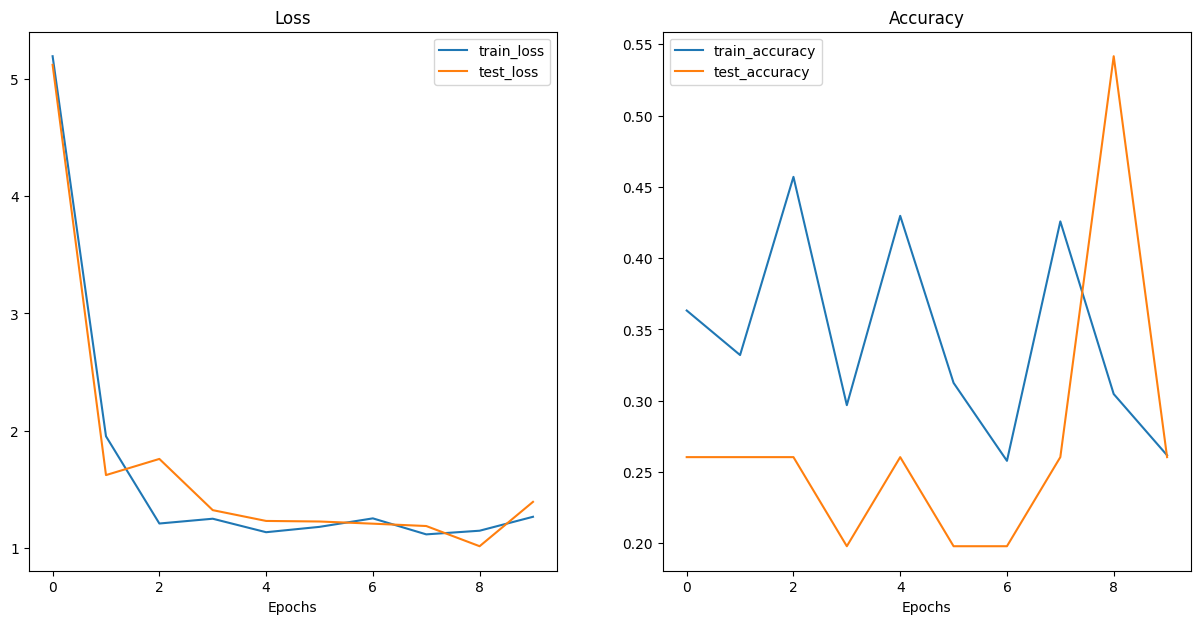

In [ ]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

Hmm, it looks like our model's loss curves are all over the place.

At least the loss looks like it's heading the right direction but the accuracy curves don't really show much promise.

These results are likely because of the difference in data resources and training regime of our ViT model versus the ViT paper.

It seems our model is [severely underfitting](learnpytorch.io/04_pytorch_custom_datasets/#82-how-to-deal-with-underfitting) (not achieving the results we'd like it to).

How about we see if we can fix that by bringing in a pretrained ViT model?

# 6. Using a pretrained ViT model from `torchvision.models` on the same dataset

Since we've now trained our own ViT from scratch and achieved less than optimal results, the benefits of transfer learning (using a pretrained model) really shine.

## 6.1 Getting a pretrained ViT model and creating a feature extractor

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
pretrained_vit

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 192MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

Notice how only the output layer is trainable, where as, all of the rest of the layers are untrainable (frozen).

And the total number of parameters, 85,800,963, is the same as our custom made ViT model above.

But the number of trainable parameters for `pretrained_vit` is much, much lower than our custom `vit` at only 2,307 compared to 85,800,963 (in our custom `vit`, since we're training from scratch, all parameters are trainable).

This means the pretrained model should train a lot faster, we could potentially even use a larger batch size since less parameter updates are going to be taking up memory.

## 6.2 Preparing data for the pretrained ViT model

In [ ]:
from helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup train and test directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Finally, we'll transform our images into tensors and turn the tensors into DataLoaders.

Since we're using a pretrained model from `torchvision.models` we can call the `transforms()` method on it to get its required transforms.

Remember, if you're going to use a pretrained model, it's generally important to **ensure your own custom data is transformed/formatted in the same way the data the original model was trained on**.

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


Since we're using a feature extractor model (less trainable parameters), we could increase the batch size to a higher value (if we set it to 1024, we'd be mimicking an improvement found in [*Better plain ViT baselines for ImageNet-1k*](https://arxiv.org/abs/2205.01580), a paper which improves upon the original ViT paper and suggested extra reading). But since we only have ~200 training samples total, we'll stick with 32.

In [ ]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)

## 6.3 Train feature extractor ViT model

We'll use the Adam optimizer (`torch.optim.Adam()`) with a learning rate of `0.001` and `torch.nn.CrossEntropyLoss()` as the loss function.

In [ ]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0001 | train_acc: 1.0000 | test_loss: 0.3457 | test_acc: 0.9081
Epoch: 2 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 0.3391 | test_acc: 0.9384
Epoch: 3 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 0.3470 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 0.3522 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 0.3569 | test_acc: 0.9081
Epoch: 6 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 0.3600 | test_acc: 0.9081
Epoch: 7 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 0.3684 | test_acc: 0.9081
Epoch: 8 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 0.3716 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 0.3738 | test_acc: 0.9081
Epoch: 10 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 0.3710 | test_acc: 0.9384


Looks like our pretrained ViT feature extractor performed far better than our custom ViT model trained from scratch (in the same amount of time).

Let's get visual.

## 6.4 Plot feature extractor ViT model loss curves

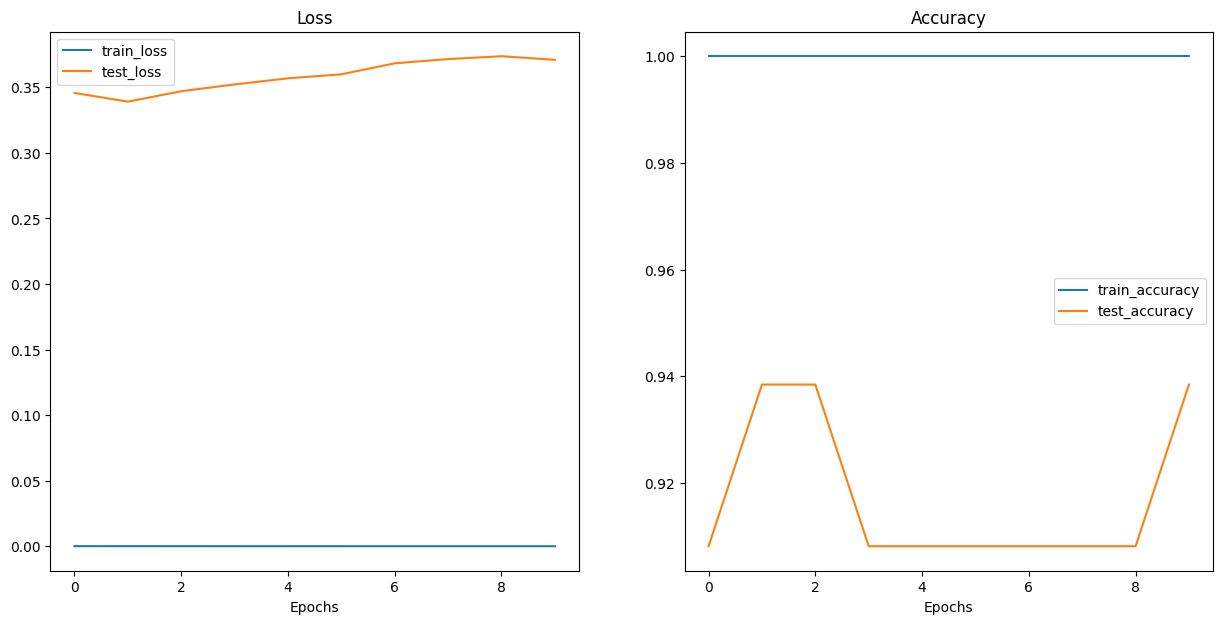

In [ ]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

Those are some close to textbook looking (really good) loss curves.

That's the power of transfer learning!

We managed to get outstanding results with the *same* model architecture, except our custom implementation was trained from scratch (worse performance) and this feature extractor model has the power of pretrained weights from ImageNet behind it.

## 6.5 Save feature extractor ViT model and check file size

It looks like our ViT feature extractor model is performing quite well for our Food Vision Mini problem.

Perhaps we might want to try deploying it and see how it goes in production (in this case, deploying means putting our trained model in an application someone could use, say taking photos on their smartphone of food and seeing if our model thinks it's pizza, steak or sushi).

In [ ]:
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


Looks like our ViT feature extractor model for Food Vision Mini turned out to be about 327 MB in size.

# 7. Make Predictions on a Custom Image

Let's download the pizza dad image (a photo of my dad eating pizza) and use our ViT feature extractor to predict on it.

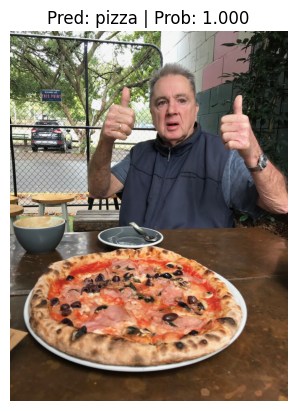

In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

The model has successfully predicted our custom image!